## Mammals

In [16]:
import numpy as np
import matplotlib as plt
import geopandas as gpd
import os

In [18]:
os.getcwd()

'C:\\Users\\nooriza maharani\\Documents\\Dissertation'

In [20]:
mammal = gpd.read_file('MAMMALS_TERRESTRIAL_ONLY.shp')
borneo_boundary = gpd.read_file('gadm41_Borneo.shp')

In [26]:
bird = gpd.read_file('BOTW_2024_2.gpkg')

C:\Anaconda\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'BOTW_2024_2.gpkg': 'all_species' (default), 'main_BL_HBW_Checklist_V9'. Specify layer parameter to avoid this warning.
  result = read_func(


In [30]:
import fiona

# List all layers in the GPKG file
layers = fiona.listlayers("BOTW_2024_2.gpkg")
print(layers)

['all_species', 'main_BL_HBW_Checklist_V9']


In [24]:
borneo_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
mammal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
bird.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Clipping Mammals with Borneo Boundary

In [43]:
# Cek geometri yang tidak valid
invalid = mammal[~mammal.is_valid]
print(invalid)

      id_no             sci_name  presence  origin  seasonal      compiler  \
2535   9760  Helarctos malayanus         5       1         1  Graham Usher   
9831  41772         Sus barbatus         1       1         1          IUCN   

      yrcompiled                                           citation  \
2535        2017               Scotson, L. and Fredriksson, G. 2016   
9831        2017  IUCN (International Union for Conservation of ...   

     subspecies subpop  ... marine terrestria freshwater  SHAPE_Leng  \
2535       None   None  ...  false       true      false  298.047663   
9831   barbatus   None  ...  false       true      false  203.352979   

      SHAPE_Area           area  \
2535   28.227425  347094.755252   
9831   29.450292  362205.059335   

                                                habitat altitude max_alt  \
2535          Forest, Shrubland, Artificial/Terrestrial      1.0  3000.0   
9831  Forest, Wetlands (inland), Marine Neritic, Mar...      0.0     0.0   


In [64]:
# Select animals which presence is not extinct and resident through the year
mammals_filtered = mammal[(mammal['presence'] != 5) & (mammal['seasonal'] == 1)].copy()

In [68]:
len(mammals_filtered)

12450

In [90]:
from shapely.validation import make_valid

mammals_filtered["geometry"] = mammals_filtered["geometry"].apply(make_valid)
borneo_boundary["geometry"] = borneo_boundary["geometry"].apply(make_valid)

In [92]:
mammals_borneo = gpd.clip(mammals_filtered, borneo_boundary)

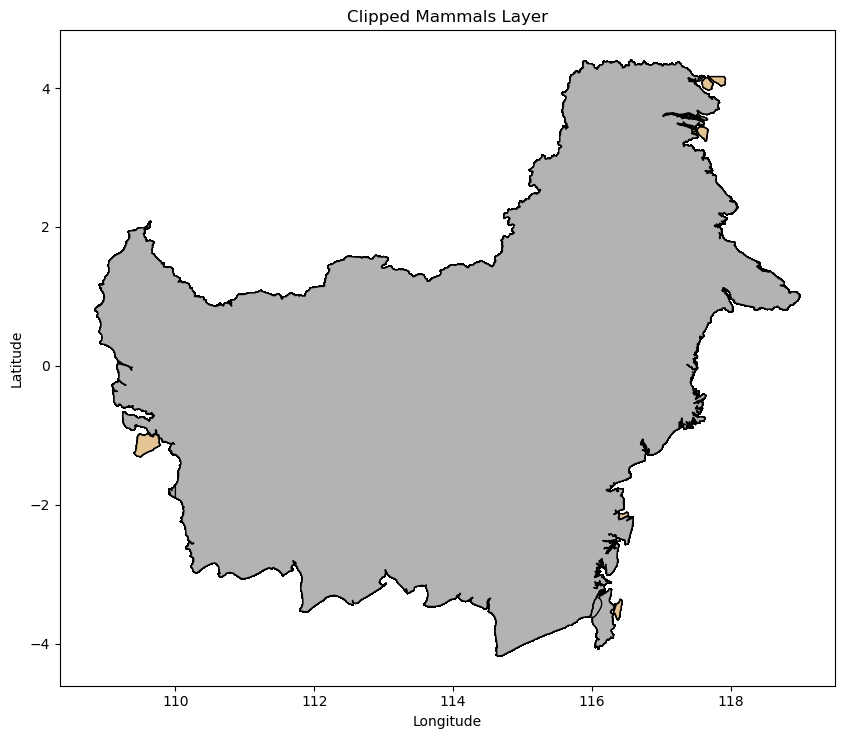

In [94]:
# Plot the clipped layer
mammals_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped Mammals Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [142]:
# Select animals where yrcompiled > 2000 and category as CR, VU, EN
mammals_threatened = mammals_borneo[
    (mammals_borneo['category'].isin(['VU', 'CR', 'EN'])) &
    (mammals_borneo['yrcompiled'] > 2000)
].copy()

In [198]:
len(mammals_threatened)

58

In [230]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
mammals_borneo_proj = mammals_threatened.to_crs("ESRI:102025")

# Calculate area in square meters
mammals_borneo_proj['area_m2'] = mammals_borneo_proj.geometry.area
mammals_borneo_proj['area_km2'] = mammals_borneo_proj['area_m2'] / 1_000_000
# Remove small areas possibly the result of clipping process
mammals_borneo_proj = mammals_borneo_proj[mammals_borneo_proj['area_km2'] >= 80]

In [200]:
print(mammals_borneo_proj.columns.to_list())

['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler', 'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island', 'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum', 'class', 'order_', 'family', 'genus', 'category', 'marine', 'terrestria', 'freshwater', 'SHAPE_Leng', 'SHAPE_Area', 'area', 'habitat', 'altitude', 'max_alt', 'geometry', 'area_m2', 'area_km2']


In [234]:
# Sort by SHAPE_Area in descending order
mammals_sorted = mammals_borneo_proj.sort_values(by='area_km2', ascending=False)

# Display selected columns
#print(mammals_sorted[['sci_name', 'category', 'area_km2']])

In [214]:
# Merged duplicate species name
# Sort to keep largest area per species
sorted_gdf = mammals_borneo_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
mammals_merged = (
    sorted_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
mammals_merged = gpd.GeoDataFrame(mammals_merged, geometry='geometry', crs=mammals_borneo_proj.crs)

In [236]:
# Sort by SHAPE_Area in descending order
mammals_sort = mammals_merged.sort_values(by='sci_name', ascending=False)

# Display selected columns
#print(mammals_sort[['sci_name', 'category', 'yrcompiled', 'area_km2']])

In [226]:
len(mammals_merged)

48

In [242]:
iucn_data = pd.read_excel('mammals_database.xls')

In [244]:
mammal_aoh = mammals_merged.merge(iucn_data, on = 'sci_name', how = 'left')

In [248]:
mammal_aoh= mammal_aoh.dropna(subset=['max_alt'])

In [252]:
len(mammal_aoh)

40

In [228]:
#mammals_merged.to_file("mammals_merged.gpkg", driver = "GPKG")

In [344]:
mammal_aoh.to_file("mammal_aoh.shp")

### Clipping Birds with Borneo Boundary

In [84]:
# Invalid Geometry
invalid_bird = bird[~bird.is_valid]
print(invalid1)

Empty GeoDataFrame
Columns: [id_no, sci_name, presence, origin, seasonal, compiler, yrcompiled, citation, subspecies, subpop, source, island, tax_comm, dist_comm, generalisd, legend, kingdom, phylum, class, order_, family, genus, category, marine, terrestria, freshwater, SHAPE_Leng, SHAPE_Area, area, habitat, altitude, max_alt, geometry]
Index: []

[0 rows x 33 columns]


In [254]:
bird_borneo = gpd.clip(bird, borneo_boundary)

In [257]:
len(bird_borneo)

575

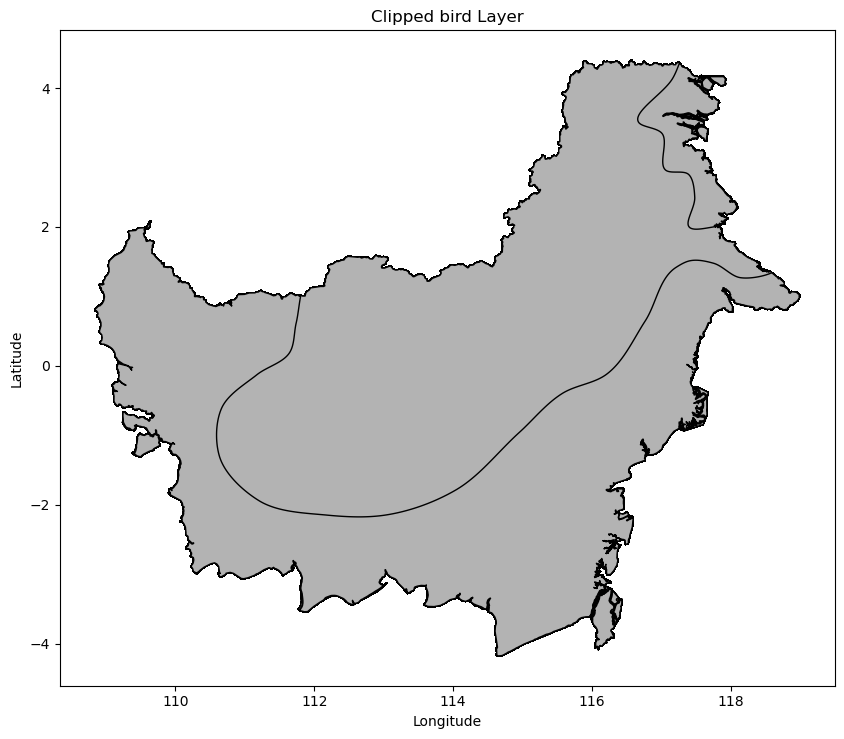

In [256]:
# Plot the clipped layer
bird_borneo.plot(figsize=(10, 10), edgecolor='black', cmap='Set2')
plt.title("Clipped bird Layer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [272]:
# Select animals which presence is not extinct and resident through the year
bird_borneo_f = bird_borneo[(bird_borneo['presence'] != 5) & (bird_borneo['seasonal'] == 1) & (bird_borneo['yrcompiled'] > 2000)].copy()

In [282]:
iucn_data_bird = pd.read_excel('birds_iucn_taxonomy.xls')

In [284]:
bird_aoh = bird_borneo_f.merge(iucn_data_bird, on = 'sci_name', how = 'left')

In [290]:
birds_threatened_aoh = bird_aoh[bird_aoh['iucn_category'].isin(['VU', 'CR', 'EN'])].copy()

In [292]:
len(birds_threatened_aoh)

41

In [296]:
# Reproject to Southeast Asia Albers Equal Area (ESRI:102025) in square metres
bird_proj = birds_threatened_aoh.to_crs("ESRI:102025")

# Calculate area in square meters
bird_proj['area_m2'] = bird_proj.geometry.area
bird_proj['area_km2'] = bird_proj['area_m2'] / 1_000_000

In [316]:
# Merged duplicate species name
# Sort to keep largest area per species
bird_gdf = bird_proj.sort_values('area_km2', ascending=False)

# Group and pick first (largest area)
bird_merged = (
    bird_gdf
    .groupby('sci_name', as_index=False)
    .agg({
        'iucn_category': lambda x: ', '.join(sorted(set(x))),
        'yrcompiled': lambda x: ', '.join(map(str, sorted(set(x)))),
        'area_km2': 'first',
        'geometry': 'first'
    })
)

# Convert to GeoDataFrame again
import geopandas as gpd
bird_merged = gpd.GeoDataFrame(bird_merged, geometry='geometry', crs=bird_proj.crs)

In [320]:
# Sort by SHAPE_Area in descending order
bird_sort = bird_merged.sort_values(by='area_km2', ascending=False)

# Display selected columns
print(bird_sort[['sci_name', 'iucn_category', 'yrcompiled', 'area_km2']])

                      sci_name iucn_category yrcompiled       area_km2
3             Argusianus argus            VU     2006.0  532128.504514
25        Rhyticeros undulatus            VU     2009.0  532128.504278
7           Buceros rhinoceros            VU     2006.0  532128.232715
10        Chloropsis sonnerati            EN     2009.0  501299.640631
19              Nisaetus nanus            VU     2013.0  457378.512112
18  Mulleripicus pulverulentus            VU     2007.0  445205.010725
6         Berenicornis comatus            EN     2014.0  421951.090901
12         Geokichla interpres            EN     2020.0  418909.123570
24  Rhabdotorrhinus corrugatus            EN     2009.0  374647.045647
5       Belocercus longicaudus            VU     2016.0  371057.686804
11              Ciconia stormi            EN     2013.0  369222.424741
15              Lophura ignita            VU     2012.0  368460.930534
29          Treron fulvicollis            VU     2013.0  356106.518840
1     

In [332]:
altitude = pd.read_excel('birds_database.xls')

In [334]:
aoh_bird = bird_merged.merge(altitude, on = 'sci_name', how = 'left')

In [336]:
print(aoh_bird)

                      sci_name iucn_category yrcompiled       area_km2  \
0       Acridotheres javanicus            VU     2020.0  300088.767750   
1       Alophoixus tephrogenys            VU     2016.0  345804.846557   
2      Anthracoceros malayanus            VU     2009.0  327884.170096   
3             Argusianus argus            VU     2006.0  532128.504514   
4       Batrachostomus auritus            VU     2022.0  247752.283695   
5       Belocercus longicaudus            VU     2016.0  371057.686804   
6         Berenicornis comatus            EN     2014.0  421951.090901   
7           Buceros rhinoceros            VU     2006.0  532128.232715   
8         Carpococcyx radiceus            VU     2022.0  187009.850638   
9         Centropus rectunguis            VU     2022.0  234326.009186   
10        Chloropsis sonnerati            EN     2009.0  501299.640631   
11              Ciconia stormi            EN     2013.0  369222.424741   
12         Geokichla interpres        

In [340]:
aoh_bird= aoh_bird.dropna(subset=['max_alt'])
len(aoh_bird)

27

In [346]:
aoh_bird.to_file("aoh_bird.shp")

C:\Users\nooriza maharani\AppData\Local\Temp\ipykernel_12136\82354377.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aoh_bird.to_file("aoh_bird.shp")
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'iucn_category' to 'iucn_categ'
  ogr_write(
C:\Anaconda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'altitudinal_range' to 'altitudina'
  ogr_write(
